## Instacart Market Basket Analysis 
## Part - II  : Data Story Telling
The objective is to predict which customer will repurchase a product in his current order, based on a anonymized dataset containing 3,000,000 orders.

Each user then has about 4 - 100 orders.

A user's reorder depends on User, the products that he purchases and the history of his purchases 

In Part- I  of the exrecise, we performed Data Wrangling. There were 6 data sets that were loaded and cleaned.
In this section of the code, Load the data and perform some Data Exploration.

 

## Extraction and Loading 

Lets take  look at a  few datasets provided

In [1]:
% matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


Read in the files 

In [2]:
order_products_train_df = pd.read_csv("../../input/order_products__train.csv")
order_products_prior_df = pd.read_csv("../../input/order_products__prior.csv")
orders_df = pd.read_csv("../../input/orders_cleaned.csv")
products_df = pd.read_csv("../../input/products.csv")
aisles_df = pd.read_csv("../../input/aisles.csv")
departments_df = pd.read_csv("../../input/departments.csv")

## Data Exploration 

### Explore  Orders  data frame
The problem here can be described as "given the prior order i.e products that were reordered, predict the products that will be reordered in new orders" 
As an example, if user A had prior orders of the products -  Bread, Eggs and Butter on Saturdays at 8:00 am, would it be possible to build a model from the training set of the latest order, if he would re-order the same three items ?

#### There are 3 data-frames of interest to explore orders
Orders.csv: Each order describes which products a user bought. This file provides 
* __order_id__ - unique identiifcation of an order
* __user_id__  - Who ordered the product
* __eval_set__  - prior /train / or test
* __order_dow__ - day on which it was ordered
* __order hour_of_the_day__ 
* __days_since_prior_order__

The prior eval set indicates a prior order.   The he new orders would belong to either prior or test eval

order_products__\*.csv: The order products file is an association between orders and the products that are in the order.  
* order_id - unique id of the order
* product_id - product_id of the product ordered
* add_to_cart_order - the order in which the product was ordered e.g. Jam was ordered 1st, then bread, then eggs
* reordered - did this product appear in a prior order ?


In [3]:
### Let's peek into the data sets 

In [4]:
# For reference we quickly tail each of the data frames
order_products_train_df.tail(2)


,order_id,product_id,add_to_cart_order,reordered
1384615,3421070,16953,2,1
1384616,3421070,4724,3,1


In [5]:
order_products_prior_df.tail(2) 
 

,order_id,product_id,add_to_cart_order,reordered
32434487,3421083,24852,9,1
32434488,3421083,5020,10,1


In [6]:
order_products_train_df.tail(2)

,order_id,product_id,add_to_cart_order,reordered
1384615,3421070,16953,2,1
1384616,3421070,4724,3,1


In [7]:
 
orders_df.tail(2)
 


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
3421081,2977660,206209,prior,13,1,12,7.0
3421082,272231,206209,train,14,6,14,30.0


In [8]:
 
products_df.tail(2)
 


,product_id,product_name,aisle_id,department_id
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8
49687,49688,Fresh Foaming Cleanser,73,11


In [9]:
 
aisles_df.tail(2) 
 


,aisle_id,aisle
132,133,muscles joints pain relief
133,134,specialty wines champagnes


In [10]:
(rows_order, cols) = order_products_train_df.shape
order_products_train_df.columns
 

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object')

In [11]:
(rows_train,cols) = order_products_train_df.groupby('order_id').count().shape

 

In [12]:
(rows_prior,cols) = order_products_prior_df.shape
order_products_prior_df.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object')

In [13]:
print("There are {} observations in the order_df  data set ".format(rows_order))
print("There are {} observations in the order_products_prior data set ".format(rows_prior))
print("There are {} observations in the order_products_train data set".format(rows_train))

There are 1384617 observations in the order_df  data set 
There are 32434489 observations in the order_products_prior data set 
There are 131209 observations in the order_products_train data set


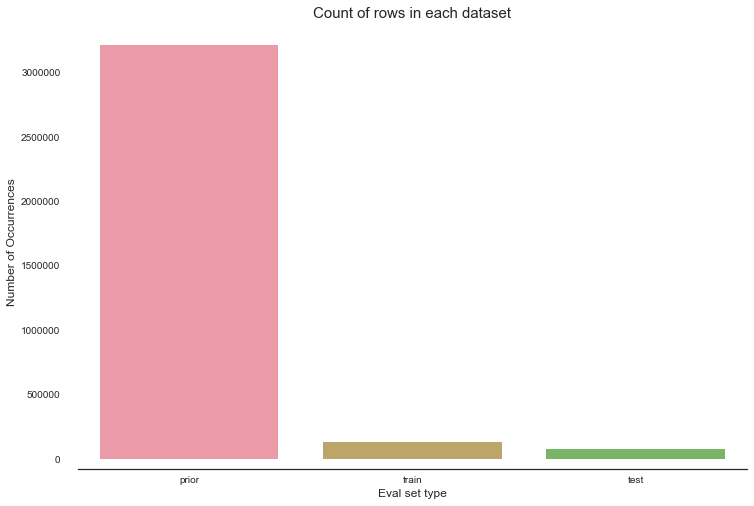

In [14]:
color = sns.color_palette()
sns.set(style="white")
cnt_srs = orders_df.eval_set.value_counts()

plt.figure(figsize=(12,8))
with sns.color_palette("husl"):
 sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
sns.set_style("whitegrid")
sns.despine(offset=10)
sns.despine(left=True)

plt.show()

__Fig. 1__:(above): First all orders are classsified as prior orders  and last order. the last order is further divided into training set and test set. So prior order provides the history of a users ordering habit. The model for prediction will need evaluation based on training set. And the final prediction model will be evaluated for accuracy on the test set.

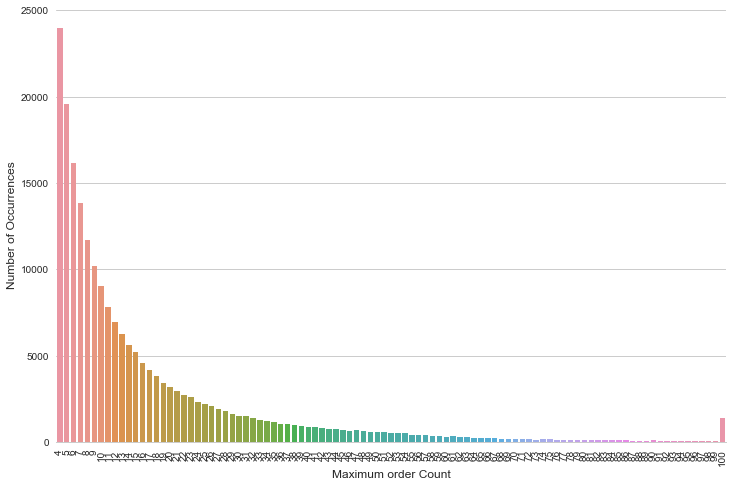

In [15]:
 
cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()
 
plt.figure(figsize=(12,8))
with sns.color_palette("husl"):
     sns.barplot(cnt_srs.index, cnt_srs.values, alpha=1.0)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order Count', fontsize=12)
plt.xticks(rotation='vertical')
sns.despine(left=True)
plt.show()
 

__Fig. 2__: (above)Each observation in orders_df data frame has order_number field. The order_number represents the order in which a user ordered products. The maximum  of the order number per customer represents the customers ordering habits - how mny products are ordered at the most by a user. We see __23,986 orders had a max of 4 products__ on one end and about __47 orders had 99 items__ in them

In [16]:
 cnt_srs.tail(3)

97    54
98    50
99    47
Name: order_number, dtype: int64

In [17]:
cnt_srs.head(3)

4    23986
5    19590
6    16165
Name: order_number, dtype: int64

About 24,000 orders were 4 in number


### Which Hour of the  day do most orders arrive ?

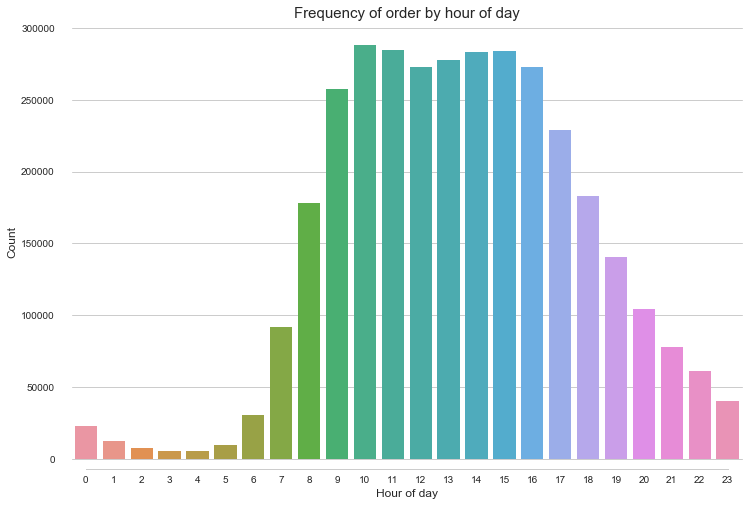

In [18]:
plt.figure(figsize=(12,8))
with sns.dark_palette("purple"):
    sns.countplot(x="order_hour_of_day", data=orders_df)
     #sns.kdeplot(x=orders_df['order_hour_of_day'], )
#sns.rugplot(x=orders_df.order_hour_of_day);
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
sns.despine(offset=10, trim=True)
sns.despine(left=True)
plt.show()



__Fig. 3__: (above) Peak ordering  hours are from __9 a.m. to 5 pm__. Most orders arrive at __10 a.m__. 

### Which day of the week do most users order ?

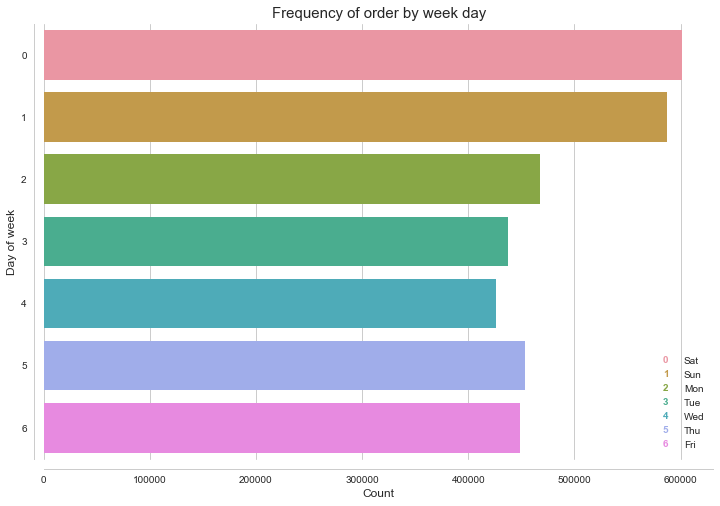

In [19]:
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text
 

class TextHandler(HandlerBase):
    def create_artists(self, legend, tup ,xdescent, ydescent,
                        width, height, fontsize,trans):
        tx = Text(width/2.,height/2,tup[0], fontsize=fontsize,
                  ha="center", va="center", color=tup[1], fontweight="bold")
        return [tx]


plt.figure(figsize=(12,8))
with sns.color_palette("husl"):
    ax = sns.countplot(y="order_dow", data=orders_df)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
#plt.yticklabels = ['Sa','Sun','Mon','Tue','Wed', 'Thu','Fri']

handltext = ["0", "1", "2", "3", "4", "5","6"]
labels = ["Sat", "Sun", "Mon", "Tue", "Wed", "Thu", "Fri"]


t = ax.get_yticklabels()
labeldic = dict(zip(handltext, labels))
labels = [labeldic[h.get_text()]  for h in t]
handles = [(h.get_text(),c.get_fc()) for h,c in zip(t,ax.patches)]

ax.legend(handles, labels, handler_map={tuple : TextHandler()}) 


sns.despine(offset=10)
plt.show()

__Fig. 4__: (above) : Orders arrive the most on __Saturday and Sunday__

### When do most users order ?

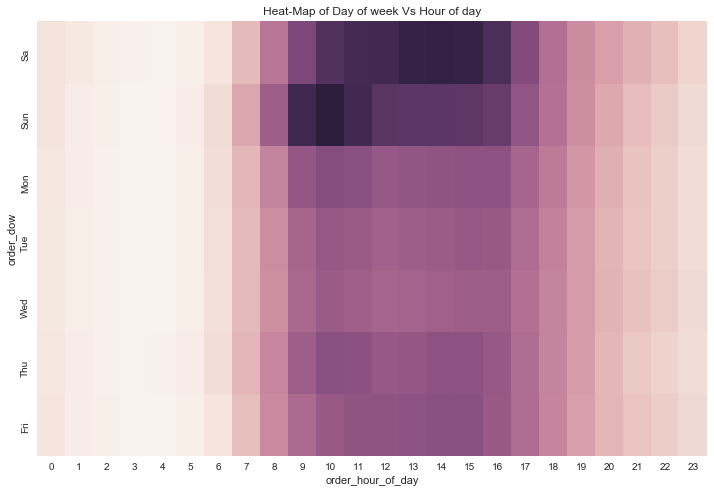

In [20]:
grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,8))
with sns.color_palette("coolwarm",7):
#with sns.color_palette("cubehelix", 7)    
  ax = sns.heatmap(grouped_df, cbar=None, linecolor='White', yticklabels=['Sa','Sun','Mon','Tue','Wed','Thu','Fri'])
  
plt.title("Heat-Map of Day of week Vs Hour of day")
plt.show()

__Fig. 5__ : (above)Users order the most on __a Saturday afternoon or Sunday morning__.

### How often do Users place order ?


In [21]:
# Here we round to integer the days to next rder and count them
days_to_next_order_df = orders_df.round({'days_since_prior_order':0})
 

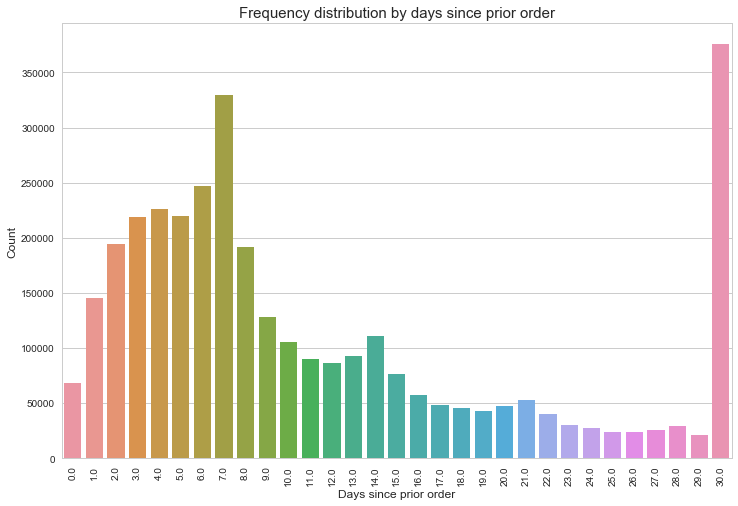

In [22]:
plt.figure(figsize=(12,8))

sns.countplot(x="days_since_prior_order", data=days_to_next_order_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

__Fig. 6__: (above) Most orders are ordered either __every 30 days or every 6 or 7 days__

## Let's Explore Prior Orders
We do this by merging the products, aisle and department info to the prior orders data frame

In [23]:
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head(5)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


### What are the most ordered products ?

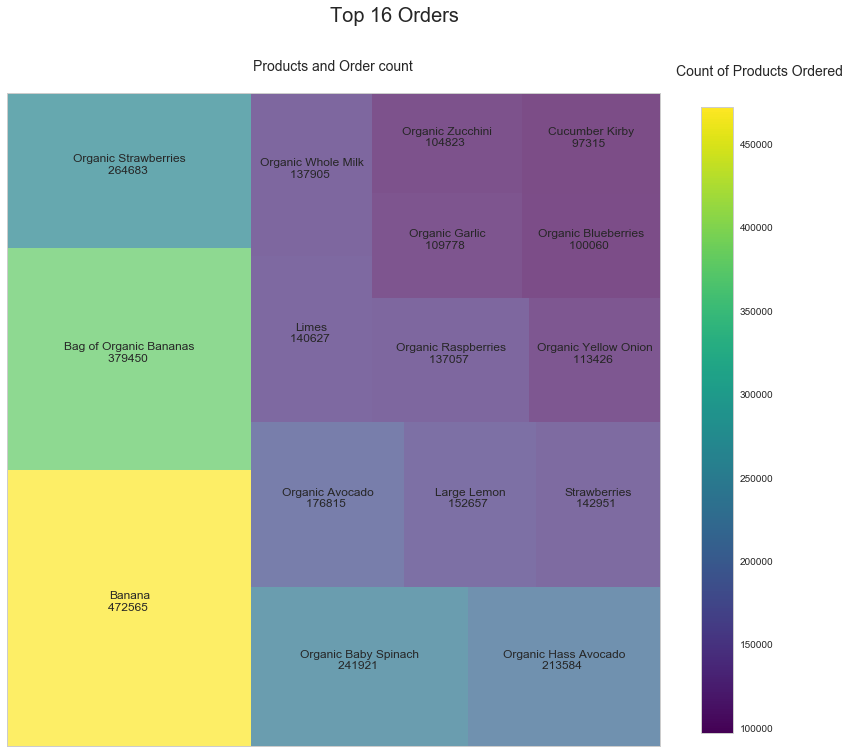

In [51]:
top_ten_products = order_products_prior_df['product_name'].value_counts().reset_index().head(16)
top_ten_products.columns = ['product_name', 'frequency_count']
top_ten_products.head(5)



import squarify
from matplotlib import cm 
from matplotlib import colors

 

df2=top_ten_products

 
# treemap parameters
x = 0.
y = 0.
width = 100.
height = 100.
cmap = cm.viridis

 
# color scale on the reordered
# min and max values without Pau
#mini, maxi = df2.drop("PAU").p11_pop.min(), df2.drop("PAU").p11_pop.max()
mini, maxi = df2.frequency_count.min(), df2.frequency_count.max()
norm = colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in df2.frequency_count]
 
# labels for squares
labels = ["%s\n%d \n" % (label) for label in zip( df2.product_name, df2.frequency_count)]


 
# make plot
fig = plt.figure(figsize=(15, 12))
fig.suptitle("Top 16 Orders", fontsize=20)
ax = fig.add_subplot(111, aspect="equal")
ax = fig.add_subplot()


ax = squarify.plot(sizes=df2.frequency_count, color=colors, label=labels, ax=ax, alpha=.7, linewidth=5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Products and Order count\n", fontsize=14)

# color bar
# create dummy invisible image with a color map
img = plt.imshow([df2.frequency_count], cmap=cmap)
img.set_visible(False)
fig.colorbar(img, orientation="vertical", shrink=.96)

fig.text(.76, .9, "Count of Products Ordered", fontsize=14)
 

plt.show()

__Fig. 7__: (_above_) __Bananas, Organic Bananas,  Strawberries and Spinach__ were top 3 items that were ordered.

### Which were the most re-ordered products ?

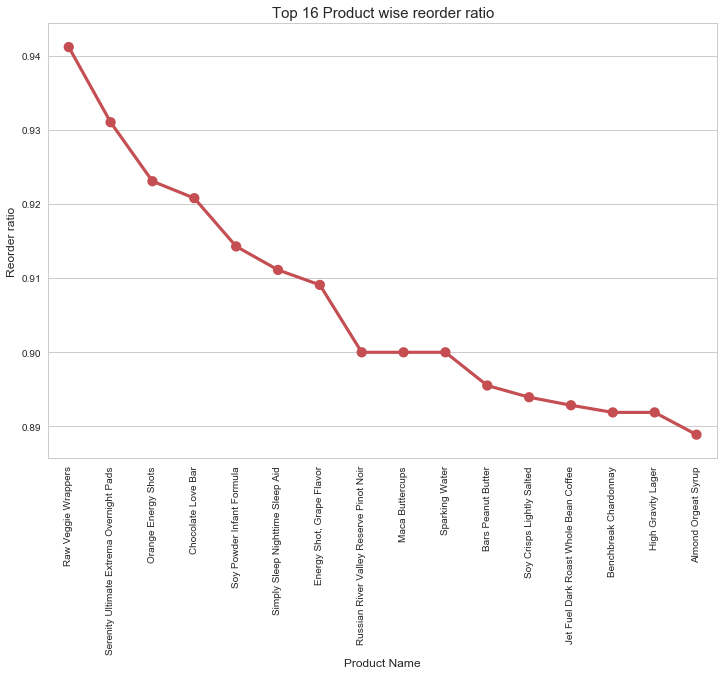

In [30]:
grouped_df = order_products_prior_df.groupby(["product_name"])["reordered"].aggregate("mean").reset_index()
re_ordered_products_df = grouped_df.sort_values(by='reordered', ascending=False).head(16)


plt.figure(figsize=(12,8))
sns.pointplot(re_ordered_products_df['product_name'].values, re_ordered_products_df['reordered'].values, alpha=0.8, color=color[2])
 

plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Product Name', fontsize=12)
plt.title("Top 16 Product wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

__Fig. 8__:(_above_) The most re-ordered item is __Raw Veggie Wrappers__

In [26]:
re_ordered_products_df.head(3)

,product_name,reordered
37375,Raw Veggie Wrappers,0.941176
39866,Serenity Ultimate Extrema Overnight Pads,0.931034
28412,Orange Energy Shots,0.923077


Table 1: (_above_) The top three products are __Veggie Wrappers, Pads, Energy Shots__

## Which department and aisles are visited for most for re-orders ? 

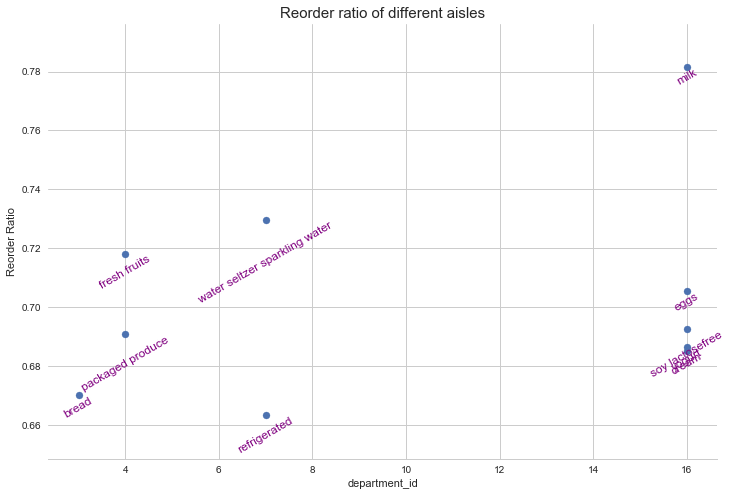

In [27]:
grouped_df = order_products_prior_df.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.sort_values(by='reordered', ascending=False).head(10)


fig, ax = plt.subplots(figsize=(12,8))
ax.scatter( grouped_df.department_id.values, grouped_df.reordered.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, ( grouped_df.department_id.values[i],grouped_df.reordered.values[i]), rotation=30, ha='center', va='top', color='purple')
plt.ylabel('Reorder Ratio')
plt.xlabel('department_id')
plt.title("Reorder ratio of different aisles", fontsize=15)
sns.despine(left=True)
plt.show()

__Fig 9:__ (_above_) The aisles __Milk, Water, Fresh Fruits__  are visited the most for re-orders. Within a Department id 16 for example, one may recommend suggesting __milk, eggs, lactose free__ aisles for reorder.
 


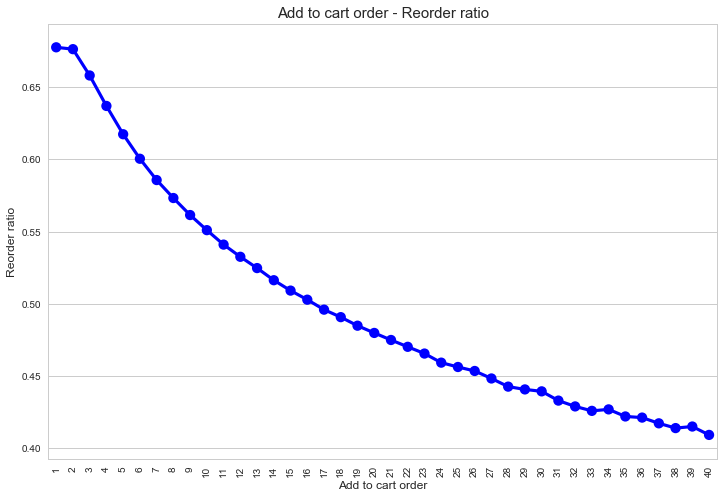

In [31]:
grouped_df = order_products_prior_df.groupby(["add_to_cart_order"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.sort_values(by='add_to_cart_order', ascending=True).head(40)

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order'].values, grouped_df['reordered'].values, alpha=0.8, color='blue')
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()



__Fig 10:__ (_above_) There is a __strong probability of a re-order if the product was added earlier in the order__. Customers tend to remember the most frequently used items and order them before browzing for new products.

### When are re-orders likely to occur ?


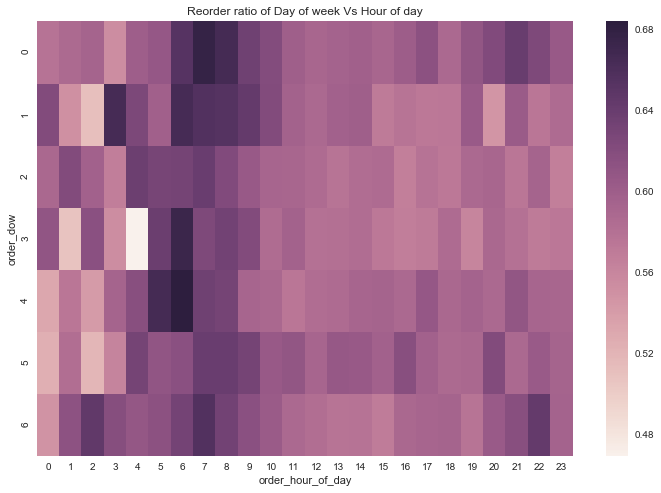

In [29]:
order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id', how='left')
grouped_df = order_products_train_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,8))
pal = sns.light_palette("navy", reverse=True)
sns.heatmap(grouped_df)
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

__Fig. 11:__(_above_) Reorders mostly occur mid-week and in early hours of the day between __6 am and 8 am__

### SUMMARY  : 
* Peak orders Arrive at 10 am
* Sat and Sunday are the most popular days to order
* Saturday afternoon and Sunday Morning are busy days for ordering 
* Most customers order every 7 days or every 30 days
* Bananas are the most ordered items
* Raw Veggie wrappers and Sanitary Pads are most reordered items
* Most popular ailses to re-order from  are Milk, Water and Fresh Fruits
* For a product if the age order was low, it is likely to be re-ordered
* Most Reorders arrive in the Morning
